In [28]:
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
import nashpy as nash
import optuna

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison,distribution_comparison, generate_outputs_from_distribution
from utils.plot import two_action_prob_plot

from algorithm_single_state import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer, SPPOClosedForm
from policy import UniformPolicyModel,PolicyModel,Ref_PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order

In [29]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [30]:
state_dim = 1
actions = [-10,0,10]

### Collect data

In [31]:
torch.manual_seed(5)
feature_func = NonMonotonicScalarToVectorNN()
pref_dataset, p_list = collect_preference_data(actions,60,feature_func)

In [32]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [33]:
pref_dataset

[Transition(state=array([0]), action_0=-10, action_1=0, pref=1, chosen_probs=0.24510111981513732),
 Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.44118222864585355),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=1, chosen_probs=0.5588177713541465),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.44118222864585355),
 Transition(state=

In [34]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

print(f"states: {states}")
print(f"positive_actions: {positive_actions}")
print(f"negative_actions: {negative_actions}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset)}")

states: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
positive_actions: tensor([1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 2, 2, 1,
        2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1,
        0, 1, 2, 0, 1, 2, 1, 1, 1, 0, 1, 0])
negative_actions: tensor([0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2,
        1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 0, 2, 2, 1, 2,
        1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 1])
check transition: (True, ('-10', '0', '10'))
check data consistency: 0.8


## Nash equilibrium

In [35]:
# compute nash equilibrium

A = np.array([
    [0.5, 0.1, 0.8],
    [0.9, 0.5, 0.1],
    [0.2, 0.9, 0.5]
])


game = nash.Game(p_list, -p_list)

#game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]


In [36]:
# compute nash equilibrium

A = np.array([
    [0.5, 0.51, 0.51],
    [0.49, 0.5, 0.51],
    [0.49, 0.49, 0.5]
])


# game = nash.Game(p_list, -p_list)

game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [1. 0. 0.]


In [37]:
# We use action 0 and action 1 to plot the scatter plot
nash_point= [eq[0][0],eq[0][1]]
nash_point

[1.0, 0.0]

## 1 state 1 action intransitive data

### RLHF

In [38]:
learned_reward_model = RewardModel(
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [39]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [40]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-12-05 15:14:36,707 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 0 loss: 0.6777 acc: 0.77
2024-12-05 15:14:36,715 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 2 loss: 0.6746 acc: 0.77
2024-12-05 15:14:36,721 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 4 loss: 0.6717 acc: 0.77
2024-12-05 15:14:36,726 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 6 loss: 0.6688 acc: 0.77
2024-12-05 15:14:36,731 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 8 loss: 0.6659 acc: 0.77
2024-12-05 15:14:36,736 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 10 loss: 0.6632 acc: 0.77
2024-12-05 15:14:36,741 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] E

In [41]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]])
tensor([[0.7000, 0.2000, 0.1000]])
tensor([[1., 0., 0.]])
tensor([[0.1000, 0.3000, 0.6000]])


In [42]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 
states.shape

torch.Size([60, 1])

In [43]:
# pg
policy_pg_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_pg_4 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [44]:
pg_optimizer_1 = PolicyGradientOptimizer(
    policy=policy_pg_1,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

pg_optimizer_2 = PolicyGradientOptimizer(
    policy=policy_pg_2,
    reward_model=learned_reward_model,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

pg_optimizer_3 = PolicyGradientOptimizer(
    policy=policy_pg_3,
    reward_model=learned_reward_model,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

pg_optimizer_4 = PolicyGradientOptimizer(
    policy=policy_pg_4,
    reward_model=learned_reward_model,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-12-05 15:14:36,939 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 0 loss: -0.2827 reward: 0.2827 ref_reward: 0.2734 improvement: 3.39%
2024-12-05 15:14:37,183 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 2 loss: -0.2833 reward: 0.2833 ref_reward: 0.2734 improvement: 3.64%
2024-12-05 15:14:37,427 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 4 loss: -0.2831 reward: 0.2831 ref_reward: 0.2734 improvement: 3.55%
2024-12-05 15:14:37,669 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 6 loss: -0.2834 reward: 0.2834 ref_reward: 0.2734 improvement: 3.65%
2024-12-05 15:14:37,912 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 8 loss: -0.2834 reward: 0.2834 ref_reward: 0.2734 improvement: 3.65%
2024-12-05 15:14:38,160 - /home/hanwen/policy

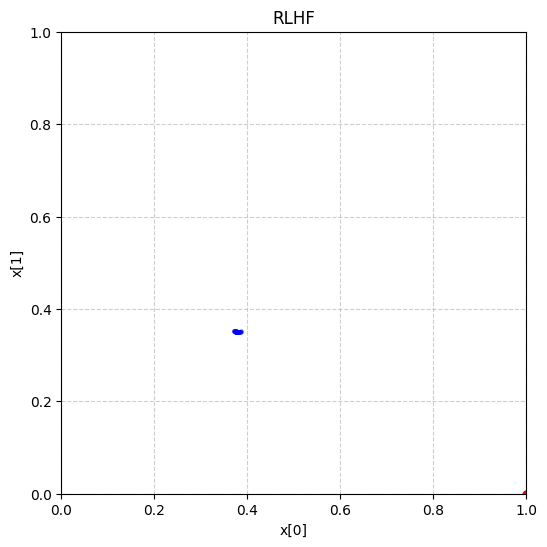

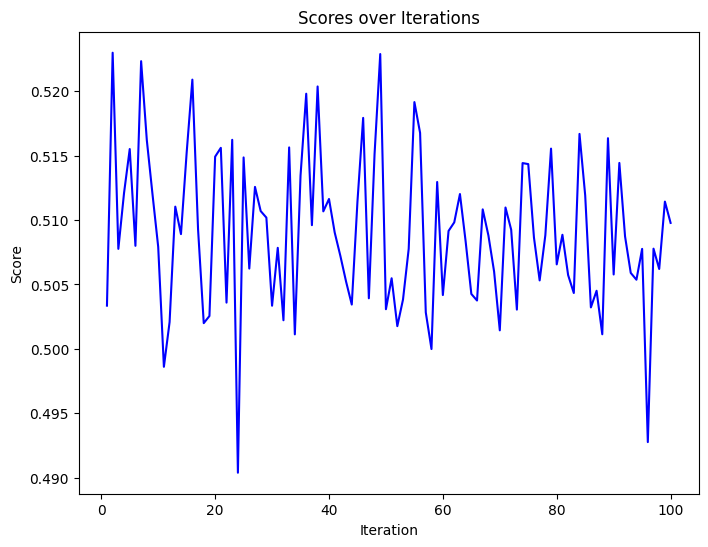

2024-12-05 15:14:46,699 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 0 loss: 0.1651 reward: -0.1651 ref_reward: 0.3541 improvement: -146.62%
2024-12-05 15:14:46,878 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 2 loss: 0.0981 reward: -0.0981 ref_reward: 0.3541 improvement: -127.70%
2024-12-05 15:14:47,058 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 4 loss: 0.0391 reward: -0.0391 ref_reward: 0.3541 improvement: -111.05%
2024-12-05 15:14:47,238 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 6 loss: -0.0135 reward: 0.0135 ref_reward: 0.3541 improvement: -96.20%
2024-12-05 15:14:47,417 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 8 loss: -0.0602 reward: 0.0602 ref_reward: 0.3541 improvement: -83.00%
2024-12-05 15:14:47,596 - /home/

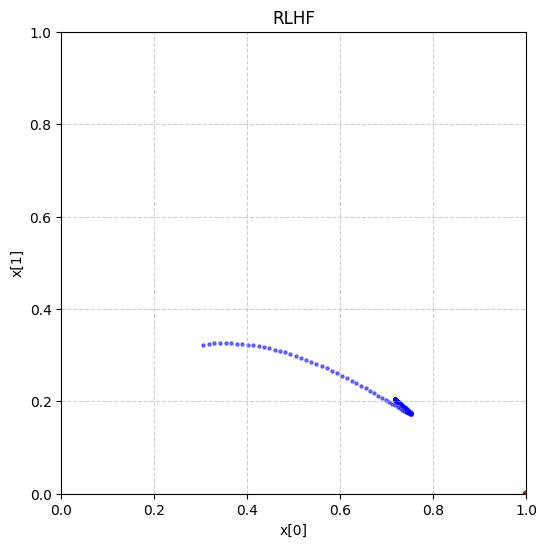

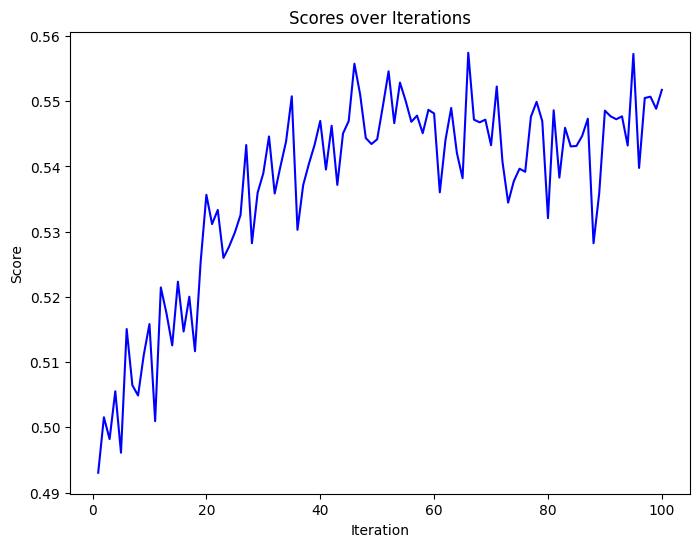

2024-12-05 15:14:58,009 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 0 loss: 14.3008 reward: -14.3008 ref_reward: 0.3861 improvement: -3804.28%
2024-12-05 15:14:58,188 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 2 loss: 13.6974 reward: -13.6974 ref_reward: 0.3861 improvement: -3647.98%
2024-12-05 15:14:58,365 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 4 loss: 13.1060 reward: -13.1060 ref_reward: 0.3861 improvement: -3494.79%
2024-12-05 15:14:58,543 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 6 loss: 12.5316 reward: -12.5316 ref_reward: 0.3861 improvement: -3346.02%
2024-12-05 15:14:58,722 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 8 loss: 11.9487 reward: -11.9487 ref_reward: 0.3861 improvement: -3195.02%
2024-12-05 15:1

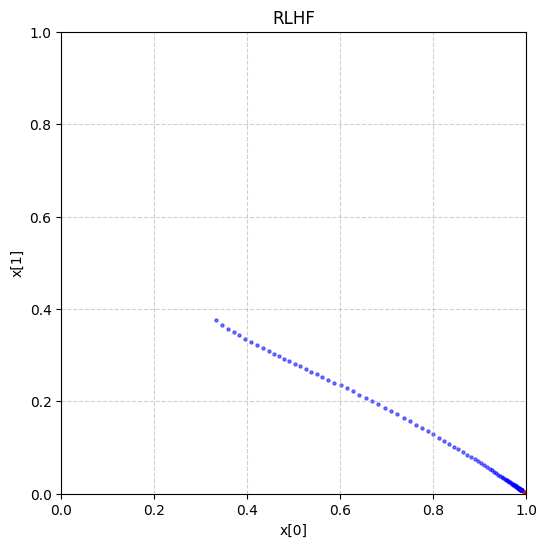

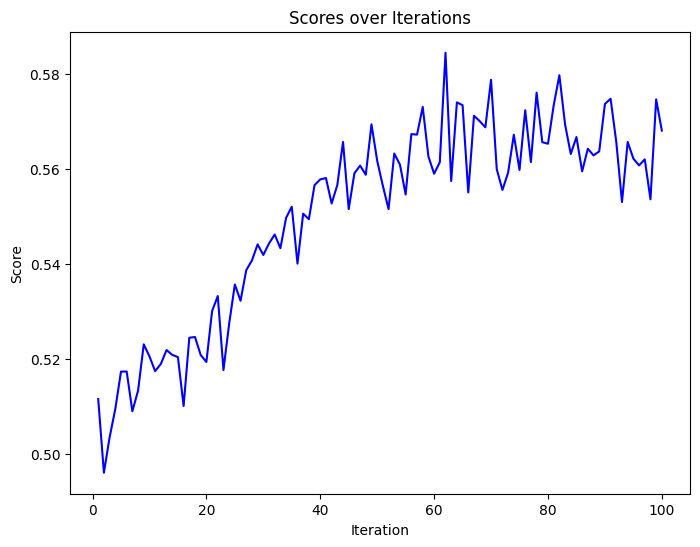

2024-12-05 15:15:07,305 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 0 loss: -0.0470 reward: 0.0470 ref_reward: 0.1811 improvement: -74.03%
2024-12-05 15:15:07,627 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 2 loss: -0.0722 reward: 0.0722 ref_reward: 0.1811 improvement: -60.16%
2024-12-05 15:15:07,950 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 4 loss: -0.0944 reward: 0.0944 ref_reward: 0.1811 improvement: -47.90%
2024-12-05 15:15:08,273 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 6 loss: -0.1133 reward: 0.1133 ref_reward: 0.1811 improvement: -37.45%
2024-12-05 15:15:08,578 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:219] - INFO: [Policy] Epoch 8 loss: -0.1303 reward: 0.1303 ref_reward: 0.1811 improvement: -28.07%
2024-12-05 15:15:08,838 - /home/han

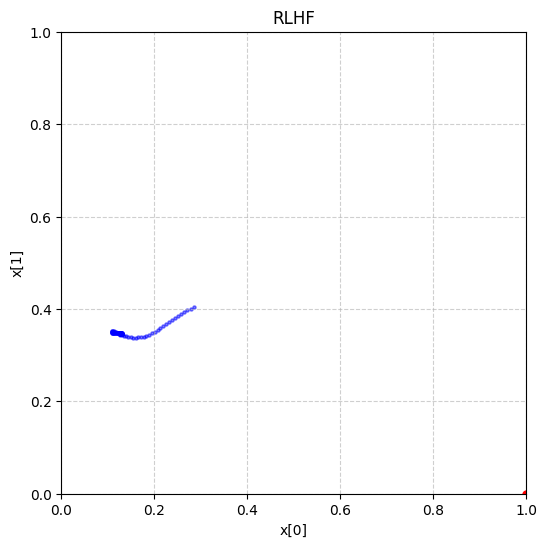

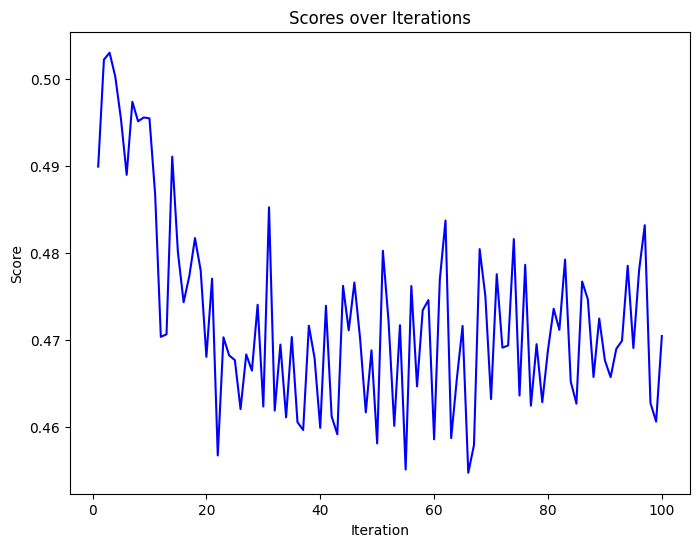

In [45]:
pg_optimizer_1.optimize(states=states, p_list=p_list, num_epochs=100) # ref_policy = uniform
pg_optimizer_2.optimize(states=states, p_list=p_list, num_epochs=100) # ref_policy = [0.7,0.2,0.1]
pg_optimizer_3.optimize(states=states, p_list=p_list, num_epochs=100) # ref_policy = [1.0,0.0,0.0]
pg_optimizer_4.optimize(states=states, p_list=p_list, num_epochs=100) # ref_policy = [0.1,0.3,0.6]


In [46]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3861], grad_fn=<ViewBackward0>)
tensor([0.0636], grad_fn=<ViewBackward0>)
tensor([0.3342], grad_fn=<ViewBackward0>)


In [47]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_pg_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy_pg_1, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score:.3f}")

with torch.no_grad():
    action_probs = policy_pg_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_pg_2, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_pg_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_pg_3, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_pg_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_pg_4, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.378
P(action=0) = 0.351
P(action=10) = 0.271

RLHF model and base model comparison score: 0.510

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.723
P(action=0) = 0.198
P(action=10) = 0.078

RLHF model and base model comparison score: 0.548

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.990
P(action=0) = 0.007
P(action=10) = 0.003

RLHF model and base model comparison score: 0.572

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.125
P(action=0) = 0.347
P(action=10) = 0.527

RLHF model and base model comparison score: 0.468


### DPO

In [48]:
policy_dpo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [49]:
dpo_optimizer_1 = DirectPreferenceOptimizer(
    policy=policy_dpo_1,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_2 = DirectPreferenceOptimizer(
    policy=policy_dpo_2,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_3 = DirectPreferenceOptimizer(
    policy=policy_dpo_3,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_4 = DirectPreferenceOptimizer(
    policy=policy_dpo_4,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-12-05 15:15:17,623 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 0 loss: 0.7014 grad norm: 0.4403 policy: 0.3039 0.3668
2024-12-05 15:15:18,062 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 5 loss: 0.6630 grad norm: 0.3568 policy: 0.3408 0.3820
2024-12-05 15:15:18,499 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 10 loss: 0.6330 grad norm: 0.2723 policy: 0.3779 0.3930
2024-12-05 15:15:18,936 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 15 loss: 0.6128 grad norm: 0.1862 policy: 0.4121 0.4012
2024-12-05 15:15:19,374 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 20 loss: 0.6020 grad norm: 0.0946 policy: 0.4416 0.4061
2024-12-05 15:15:19,811 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: 

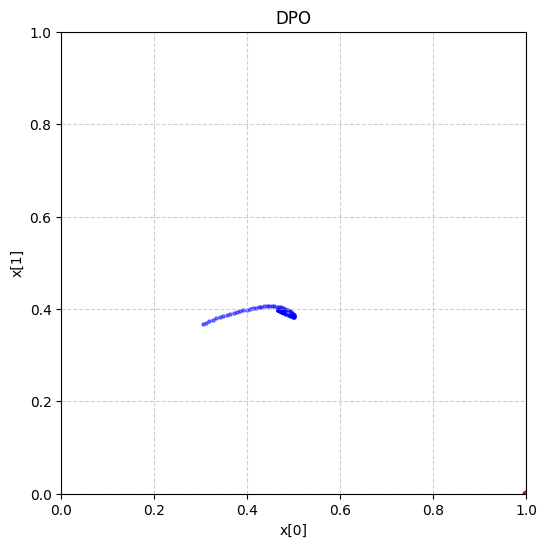

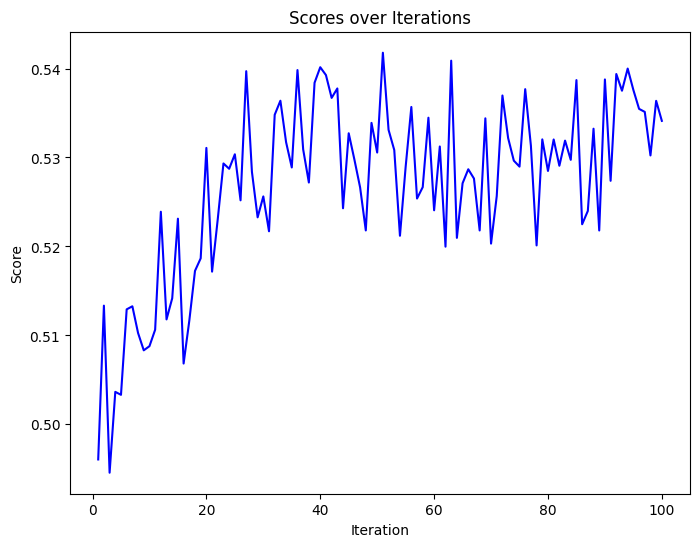

2024-12-05 15:15:26,655 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 0 loss: 1.1267 grad norm: 0.9166 policy: 0.2985 0.3851
2024-12-05 15:15:27,103 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 5 loss: 1.0492 grad norm: 0.8646 policy: 0.3387 0.3855
2024-12-05 15:15:27,546 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 10 loss: 0.9777 grad norm: 0.8539 policy: 0.3783 0.3849
2024-12-05 15:15:27,991 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 15 loss: 0.9105 grad norm: 0.8460 policy: 0.4199 0.3787
2024-12-05 15:15:28,438 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 20 loss: 0.8455 grad norm: 0.8372 policy: 0.4686 0.3621
2024-12-05 15:15:28,877 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: 

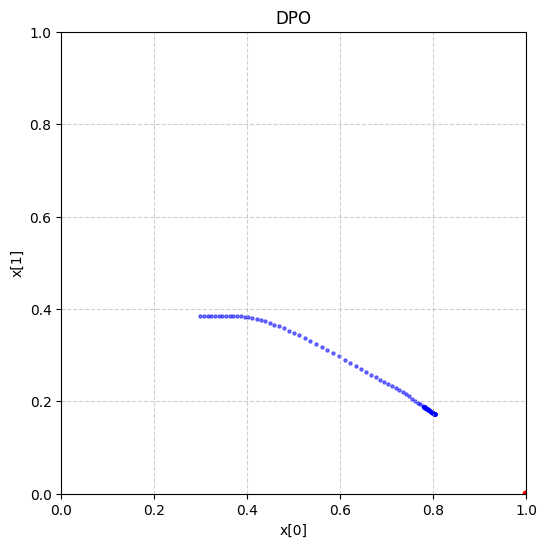

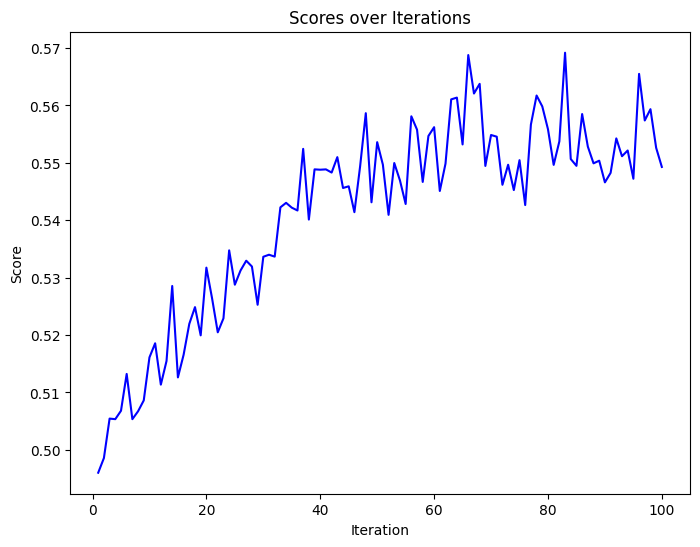

2024-12-05 15:15:35,662 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 0 loss: 9.0553 grad norm: 1.1574 policy: 0.3652 0.3544
2024-12-05 15:15:36,100 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 5 loss: 8.9285 grad norm: 1.1687 policy: 0.4396 0.3225
2024-12-05 15:15:36,538 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 10 loss: 8.8045 grad norm: 1.2360 policy: 0.5155 0.2858
2024-12-05 15:15:36,975 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 15 loss: 8.6890 grad norm: 1.3774 policy: 0.5870 0.2491
2024-12-05 15:15:37,414 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 20 loss: 8.5624 grad norm: 1.5723 policy: 0.6635 0.2076
2024-12-05 15:15:37,850 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: 

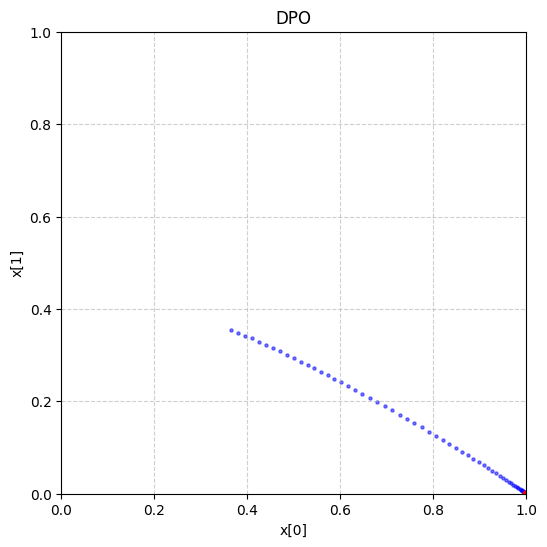

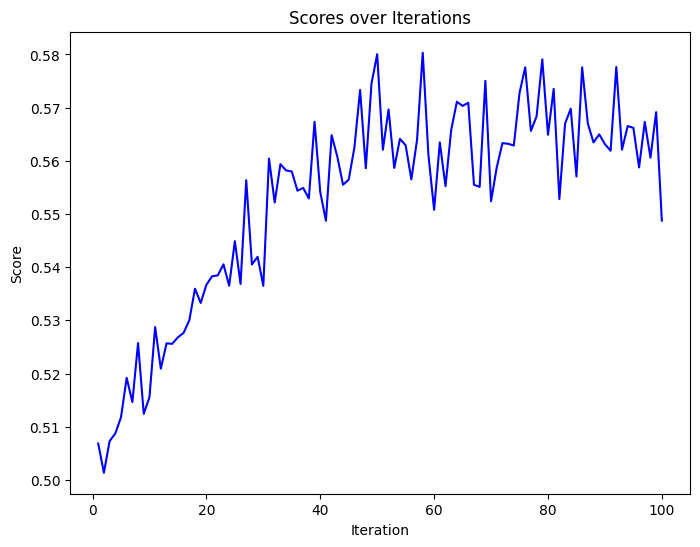

2024-12-05 15:15:44,720 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 0 loss: 0.6540 grad norm: 0.3619 policy: 0.3074 0.3177
2024-12-05 15:15:45,164 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 5 loss: 0.6253 grad norm: 0.2462 policy: 0.2790 0.3753
2024-12-05 15:15:45,622 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 10 loss: 0.6091 grad norm: 0.1542 policy: 0.2511 0.4277
2024-12-05 15:15:46,065 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 15 loss: 0.6017 grad norm: 0.0784 policy: 0.2247 0.4720
2024-12-05 15:15:46,508 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: [Policy] Epoch: 20 loss: 0.5996 grad norm: 0.0403 policy: 0.2013 0.5024
2024-12-05 15:15:46,950 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:348] - INFO: 

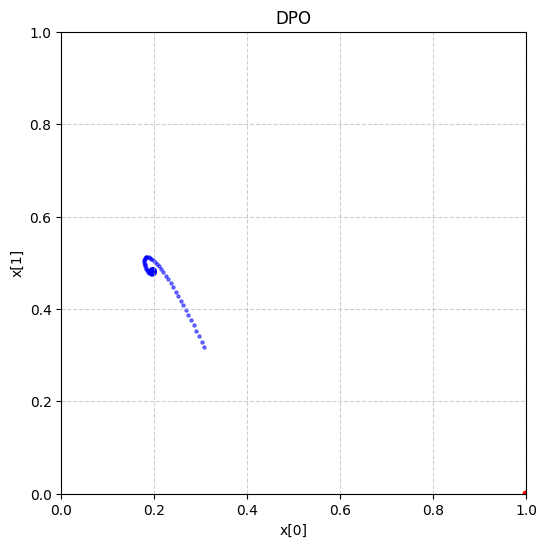

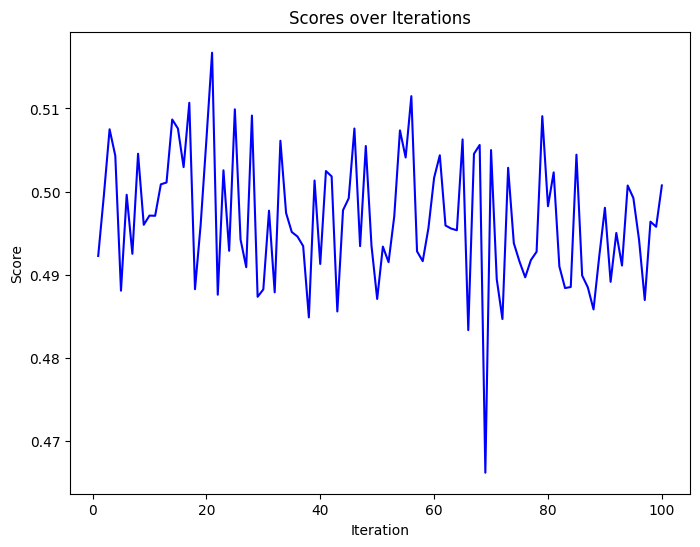

In [50]:
dpo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.33,0.33,0.33]

dpo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.7,0.2,0.1]

dpo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [1.0,0.0,0.0]

dpo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.1,0.3,0.6]

In [51]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_dpo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy_dpo_1, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_dpo_2, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_dpo_3, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_dpo_4, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.475
P(action=0) = 0.394
P(action=10) = 0.131

DPO model and base model comparison score: 0.536

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.780
P(action=0) = 0.188
P(action=10) = 0.032

DPO model and base model comparison score: 0.548

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

DPO model and base model comparison score: 0.578

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.195
P(action=0) = 0.484
P(action=10) = 0.320

DPO model and base model comparison score: 0.491


### SPPO

In [52]:
policy_sppo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [53]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [55]:
sppo_optimizer_1 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_1,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_2 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_2,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_3 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_3,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_4 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_4,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

2024-12-05 15:17:20,553 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 0 loss: 0.0093 grad norm: 0.3378 
2024-12-05 15:17:21,361 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 5 loss: 0.0117 grad norm: 0.3052 
2024-12-05 15:17:22,158 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 10 loss: 0.0009 grad norm: 0.0928 
2024-12-05 15:17:22,787 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 15 loss: 0.0002 grad norm: 0.0366 
2024-12-05 15:17:23,244 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 20 loss: 0.0016 grad norm: 0.1040 
2024-12-05 15:17:23,689 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 25 loss: 0.0006 grad norm: 0.0718 
2024-12-05 15:17:24,135 - /home/hanwen/policy_optimiza

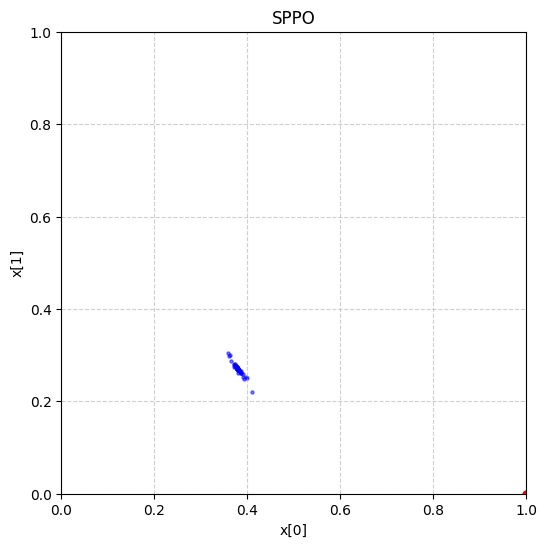

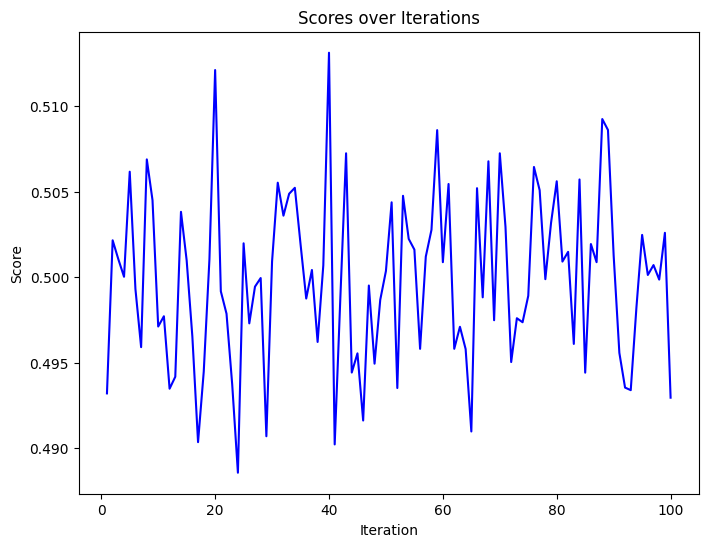

2024-12-05 15:17:30,622 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 0 loss: 1.3425 grad norm: 4.3522 
2024-12-05 15:17:31,073 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 5 loss: 0.0378 grad norm: 0.8964 
2024-12-05 15:17:31,523 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 10 loss: 0.0110 grad norm: 0.3382 
2024-12-05 15:17:31,972 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 15 loss: 0.0143 grad norm: 0.3629 
2024-12-05 15:17:32,422 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 20 loss: 0.0007 grad norm: 0.0873 
2024-12-05 15:17:32,868 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 25 loss: 0.0040 grad norm: 0.2395 
2024-12-05 15:17:33,310 - /home/hanwen/policy_optimiza

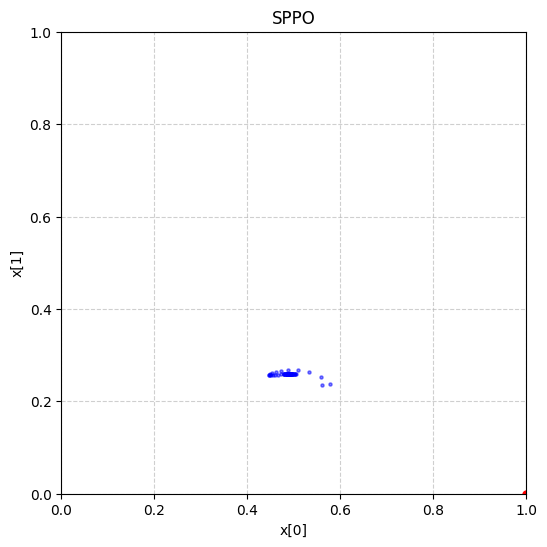

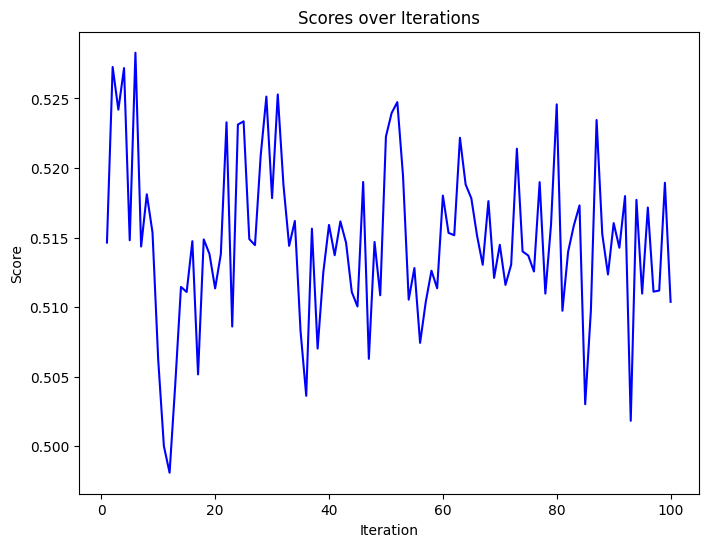

2024-12-05 15:17:39,948 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 0 loss: 672.1763 grad norm: 51.9193 
2024-12-05 15:17:40,392 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 5 loss: 0.1813 grad norm: 2.1099 
2024-12-05 15:17:40,835 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 10 loss: 0.1672 grad norm: 2.0678 
2024-12-05 15:17:41,275 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 15 loss: 0.0360 grad norm: 0.8075 
2024-12-05 15:17:41,880 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 20 loss: 0.0016 grad norm: 0.1495 
2024-12-05 15:17:42,687 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 25 loss: 0.0073 grad norm: 0.3002 
2024-12-05 15:17:43,417 - /home/hanwen/policy_optim

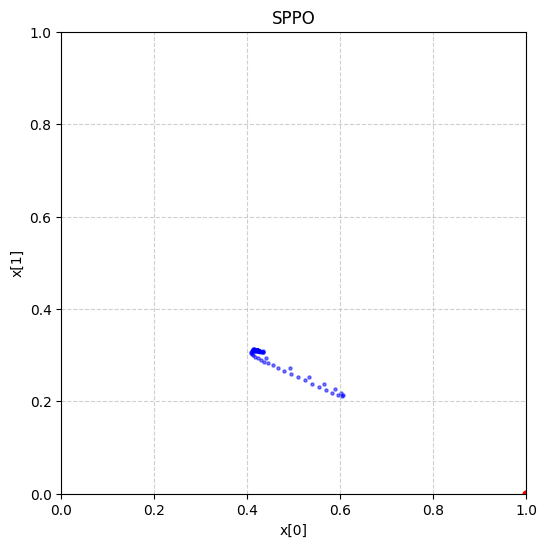

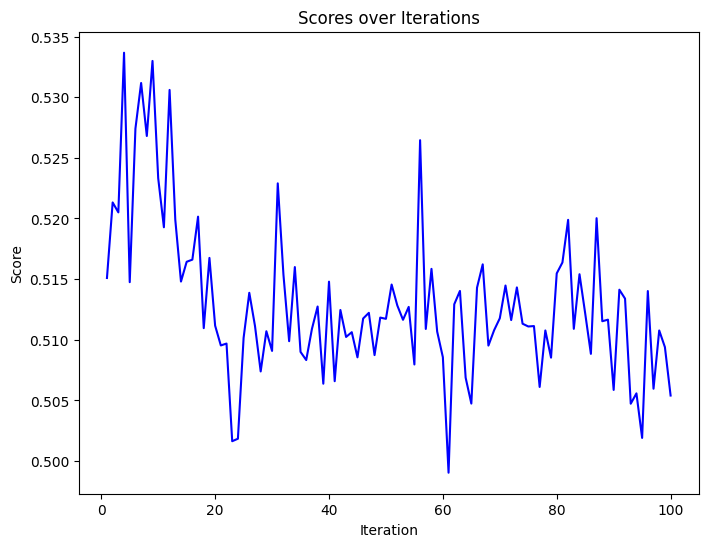

2024-12-05 15:17:50,069 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 0 loss: 1.2307 grad norm: 4.0802 
2024-12-05 15:17:50,885 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 5 loss: 0.0127 grad norm: 0.5150 
2024-12-05 15:17:51,610 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 10 loss: 0.0134 grad norm: 0.4671 
2024-12-05 15:17:52,090 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 15 loss: 0.0014 grad norm: 0.1609 
2024-12-05 15:17:52,535 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 20 loss: 0.0024 grad norm: 0.1995 
2024-12-05 15:17:52,979 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 25 loss: 0.0015 grad norm: 0.1503 
2024-12-05 15:17:53,424 - /home/hanwen/policy_optimiza

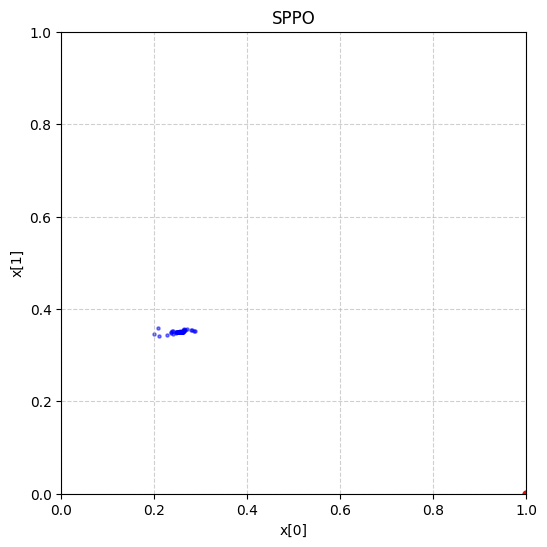

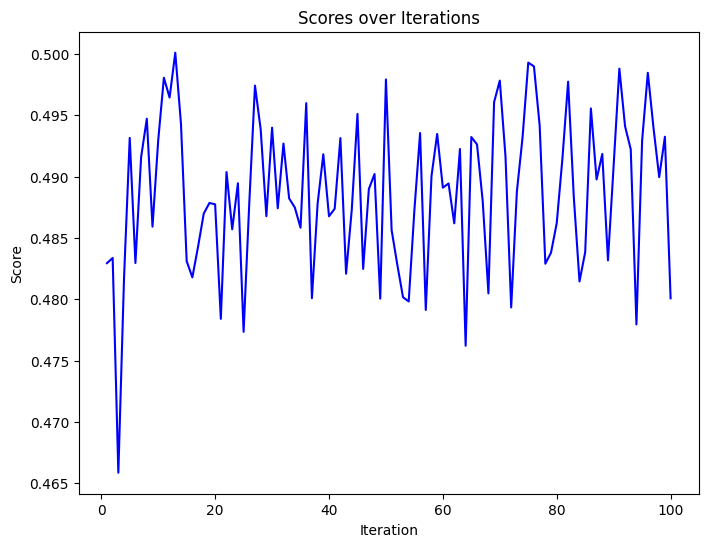

In [56]:
sppo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=100
)

sppo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=100
)

sppo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=100
)

sppo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=100
)

In [57]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_sppo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
score = model_comparison(policy_sppo_1, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


with torch.no_grad():
    action_probs = policy_sppo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_sppo_2, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_sppo_3, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_sppo_4, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.377
P(action=0) = 0.273
P(action=10) = 0.350

SPPO model and base model comparison score: 0.496

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.488
P(action=0) = 0.259
P(action=10) = 0.253

SPPO model and base model comparison score: 0.510

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.419
P(action=0) = 0.311
P(action=10) = 0.271

SPPO model and base model comparison score: 0.508

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.258
P(action=0) = 0.350
P(action=10) = 0.391

SPPO model and base model comparison score: 0.491


### SPPO Closed-form solution

In [58]:
sppo_closed_form_1 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_2 = SPPOClosedForm( 
    actions,                      
    score_ref_model = ref_policy,             
    ref_policy=ref_policy2,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_3 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy3,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_4 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy4,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

2024-12-05 15:18:00,136 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.3333, 0.3333, 0.3333]), new_distribution = tensor([0.3336, 0.3334, 0.3330])
2024-12-05 15:18:00,190 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.3336, 0.3334, 0.3330]), new_distribution = tensor([0.3338, 0.3335, 0.3327])
2024-12-05 15:18:00,245 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.3338, 0.3335, 0.3327]), new_distribution = tensor([0.3340, 0.3336, 0.3324])
2024-12-05 15:18:00,300 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.3340, 0.3336, 0.3324]), new_distribution = tensor([0.3342, 0.3337, 0.3321])
2024-12-05 15:18:00,354 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

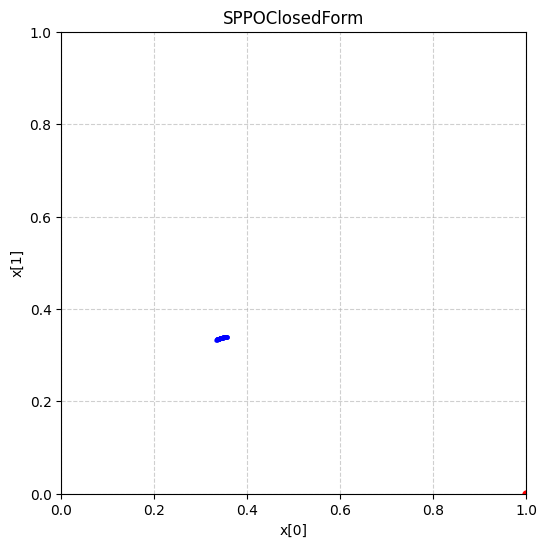

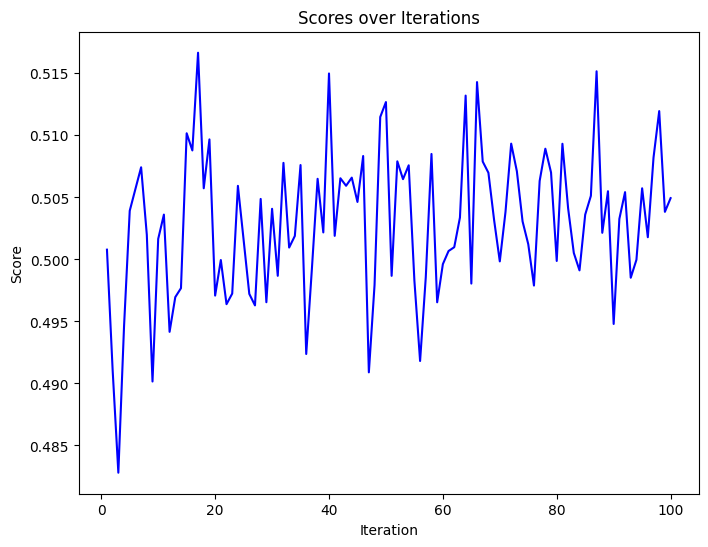

2024-12-05 15:18:05,804 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.7000, 0.2000, 0.1000]), new_distribution = tensor([0.7003, 0.1997, 0.1000])
2024-12-05 15:18:05,859 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.7003, 0.1997, 0.1000]), new_distribution = tensor([0.7006, 0.1994, 0.0999])
2024-12-05 15:18:05,914 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.7006, 0.1994, 0.0999]), new_distribution = tensor([0.7009, 0.1991, 0.0999])
2024-12-05 15:18:05,969 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.7009, 0.1991, 0.0999]), new_distribution = tensor([0.7013, 0.1988, 0.0999])
2024-12-05 15:18:06,024 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

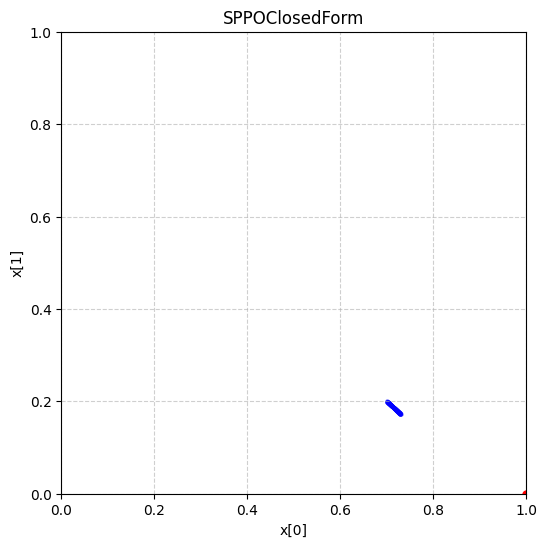

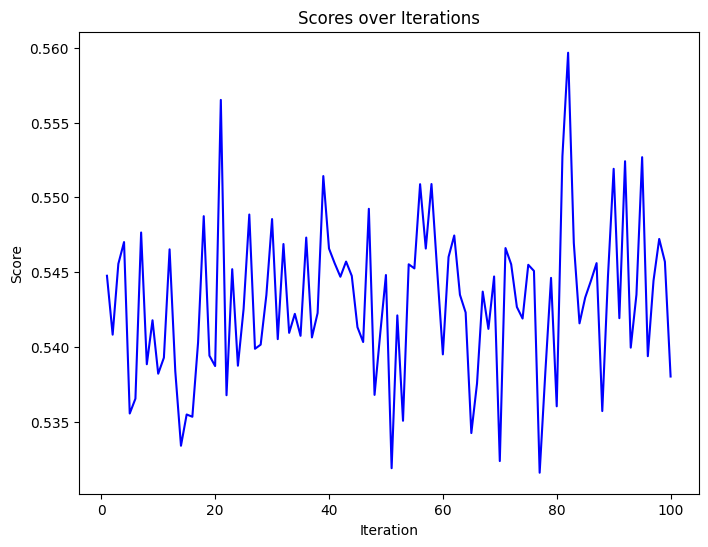

2024-12-05 15:18:11,469 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:18:11,524 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:18:11,579 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:18:11,633 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:18:11,687 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 4: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 

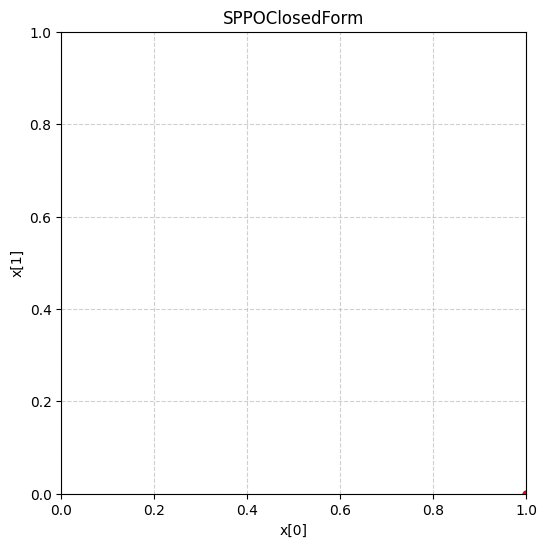

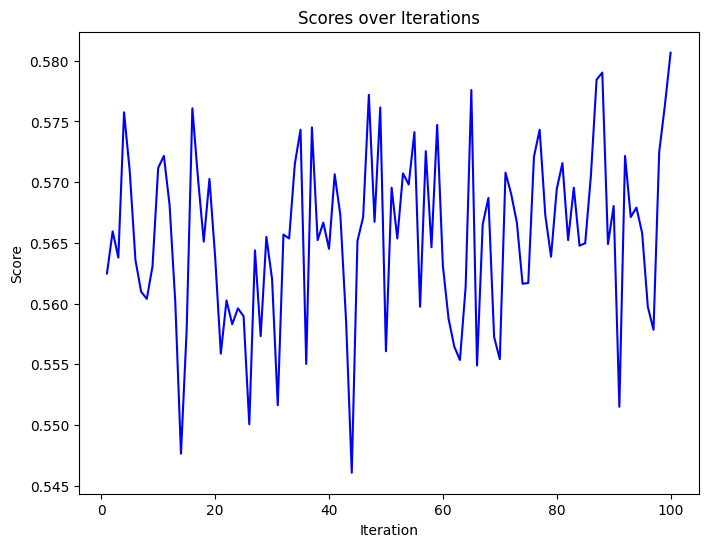

2024-12-05 15:18:17,139 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.1000, 0.3000, 0.6000]), new_distribution = tensor([0.1000, 0.3005, 0.5994])
2024-12-05 15:18:17,194 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.1000, 0.3005, 0.5994]), new_distribution = tensor([0.1001, 0.3011, 0.5989])
2024-12-05 15:18:17,249 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.1001, 0.3011, 0.5989]), new_distribution = tensor([0.1001, 0.3016, 0.5983])
2024-12-05 15:18:17,303 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.1001, 0.3016, 0.5983]), new_distribution = tensor([0.1002, 0.3021, 0.5977])
2024-12-05 15:18:17,357 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

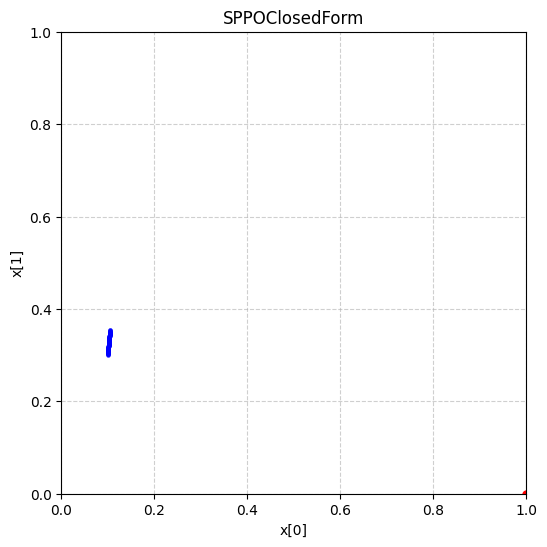

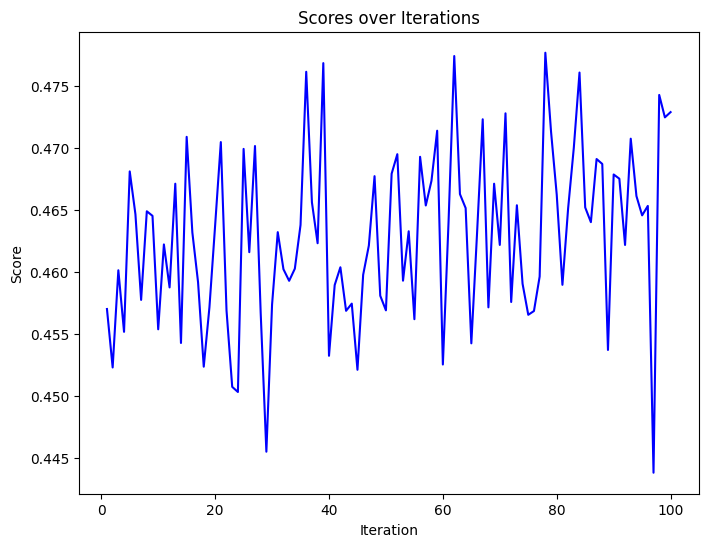

In [59]:
sppo_distribution_1 = sppo_closed_form_1.optimize(
    p_list=p_list,
    num_iters=100
)   

sppo_distribution2 = sppo_closed_form_2.optimize(
    p_list=p_list,
    num_iters=100
)

sppo_distribution3 = sppo_closed_form_3.optimize(
    p_list=p_list,
    num_iters=100
)

sppo_distribution4 = sppo_closed_form_4.optimize(
    p_list=p_list,
    num_iters=100
)

In [60]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1 = sppo_distribution_1
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = distribution_comparison(sppo_distribution_1, ref_policy,p_list)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = sppo_distribution2
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = distribution_comparison(sppo_distribution2, ref_policy,p_list)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = sppo_distribution3
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = distribution_comparison(sppo_distribution3, ref_policy,p_list)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = sppo_distribution4
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = distribution_comparison(sppo_distribution4, ref_policy,p_list)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4:.3f}")


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.356
P(action=0) = 0.340
P(action=10) = 0.304

SPPO-ClosedForm model and base model comparison score: 0.501

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.730
P(action=0) = 0.172
P(action=10) = 0.098

SPPO-ClosedForm model and base model comparison score: 0.545

Learned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

SPPO-ClosedForm model and base model comparison score: 0.579

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.105
P(action=0) = 0.354
P(action=10) = 0.540

SPPO-ClosedForm model and base model comparison score: 0.473


## 1 state 1 action transitive data

In [93]:
import numpy as np
p_list_trans =np.array([
    [0.5, 0.9, 0.8],
    [0.1, 0.5, 0.8],
    [0.2, 0.1, 0.5]  
])

In [90]:
from utils.collect_data import collect_preference_intransitive_data, check_cyclic_order, check_data_consistency
import torch

actions = [-10,0,10]
pref_dataset_trans = collect_preference_intransitive_data(p_list_intrans, actions,60)

In [91]:
pref_dataset_trans

[Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.9),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.9),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.9),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.8),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8),
 Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.9),
 Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.9),
 Tr

In [94]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states_trans = torch.tensor([x.state[0] for x in pref_dataset_trans], dtype=torch.float32).to(device).unsqueeze(1)

positive_actions_trans = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset_trans],
    dim=0
).to(device)

negative_actions_trans = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset_trans],
    dim=0
).to(device)

print(f"states: {states_trans.shape}")
print(f"positive_actions: {positive_actions_trans}")
print(f"negative_actions: {negative_actions_trans}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list_trans,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset_trans)}")

states: torch.Size([60, 1])
positive_actions: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0,
        1, 0, 1, 1, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 2, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1])
negative_actions: tensor([2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1,
        2, 1, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2,
        2, 2, 1, 0, 2, 0, 2, 2, 1, 1, 2, 2])
check transition: (False, None)
check data consistency: 0.85


In [95]:
# compute nash equilibrium

game = nash.Game(p_list_trans, -p_list_trans)

#game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [1. 0. 0.]


In [103]:
nash_point_trans= [eq[0][0],eq[0][1]]
nash_point_trans

[1.0, 0.0]

### SPPO 

In [97]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]])
tensor([[0.7000, 0.2000, 0.1000]])
tensor([[1., 0., 0.]])
tensor([[0.1000, 0.3000, 0.6000]])


In [98]:
policy_sppo_1_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_2_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_3_trans = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_4_trans = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [99]:
chosen_probs_trans = torch.tensor([x.chosen_probs for x in pref_dataset_trans], dtype=torch.float32).to(device)

In [ ]:
sppo_optimizer_1_trans = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_1_trans,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point_trans
)

sppo_optimizer_2_trans = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_2_trans,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point_trans
)

sppo_optimizer_3_trans = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_3_trans,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point_trans
)

sppo_optimizer_4_trans = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_4_trans,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point_trans
)

/home/hanwen/policy_optimization/exp/utils/utils.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
2024-12-05 15:30:33,474 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 0 loss: 0.0582 grad norm: 1.0254 
2024-12-05 15:30:34,080 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 5 loss: 0.0162 grad norm: 0.4297 
2024-12-05 15:30:34,689 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 10 loss: 0.0007 grad norm: 0.0900 
2024-12-05 15:30:35,296 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 15 loss: 0.0032 grad norm: 0.1844 
2024-12-05 15:30:35,816 - /home/hanwen/poli

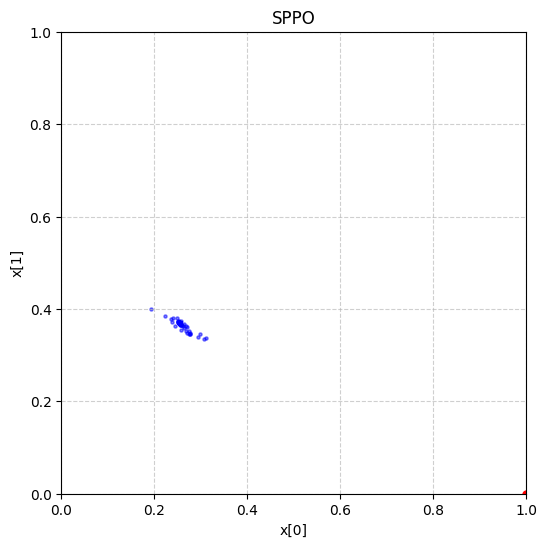

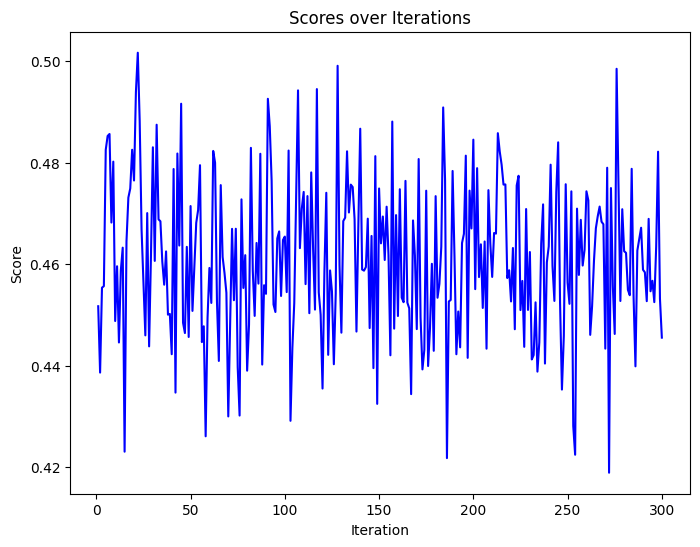

2024-12-05 15:31:00,816 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 0 loss: 1.5002 grad norm: 4.2627 
2024-12-05 15:31:01,310 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 5 loss: 0.0381 grad norm: 0.8816 
2024-12-05 15:31:01,750 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 10 loss: 0.0157 grad norm: 0.3760 
2024-12-05 15:31:02,190 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 15 loss: 0.0168 grad norm: 0.3764 
2024-12-05 15:31:02,631 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 20 loss: 0.0000 grad norm: 0.0123 
2024-12-05 15:31:03,072 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 25 loss: 0.0065 grad norm: 0.3033 
2024-12-05 15:31:03,512 - /home/hanwen/policy_optimiza

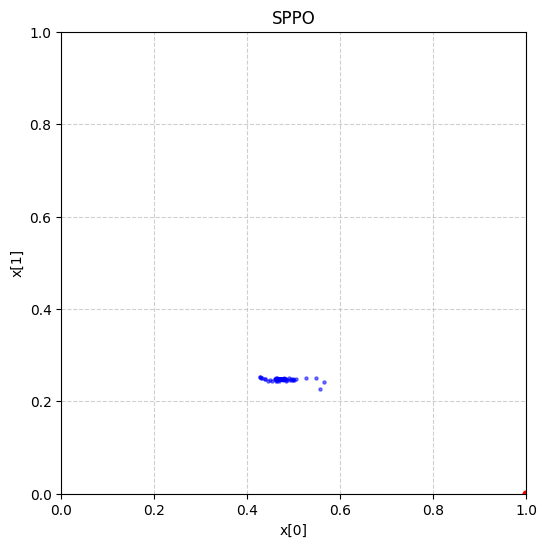

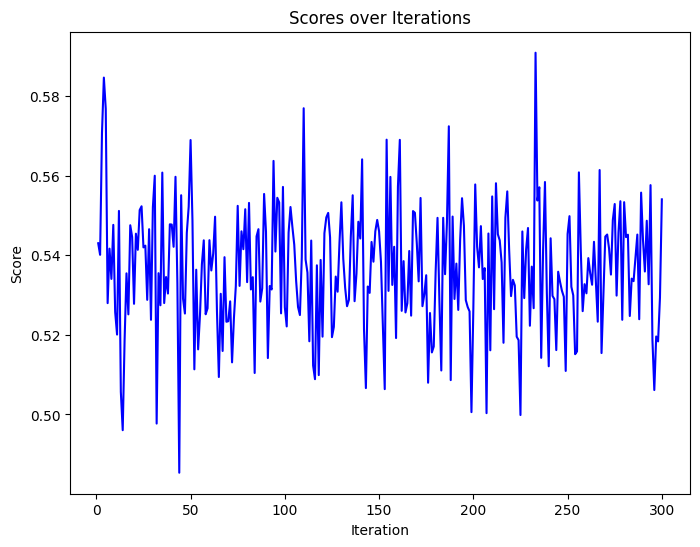

2024-12-05 15:31:27,501 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 0 loss: 641.1761 grad norm: 49.4679 
2024-12-05 15:31:27,943 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 5 loss: 0.4025 grad norm: 4.1884 
2024-12-05 15:31:28,384 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 10 loss: 0.2915 grad norm: 3.4406 
2024-12-05 15:31:28,826 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 15 loss: 0.0217 grad norm: 0.7434 
2024-12-05 15:31:29,268 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 20 loss: 0.0131 grad norm: 0.5146 
2024-12-05 15:31:29,710 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 25 loss: 0.0415 grad norm: 0.8770 
2024-12-05 15:31:30,154 - /home/hanwen/policy_optim

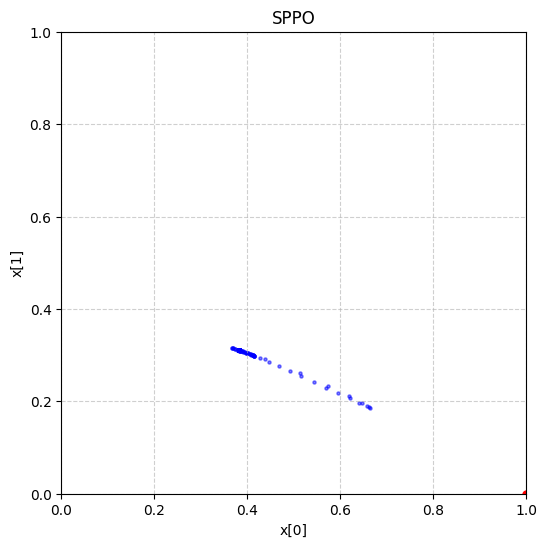

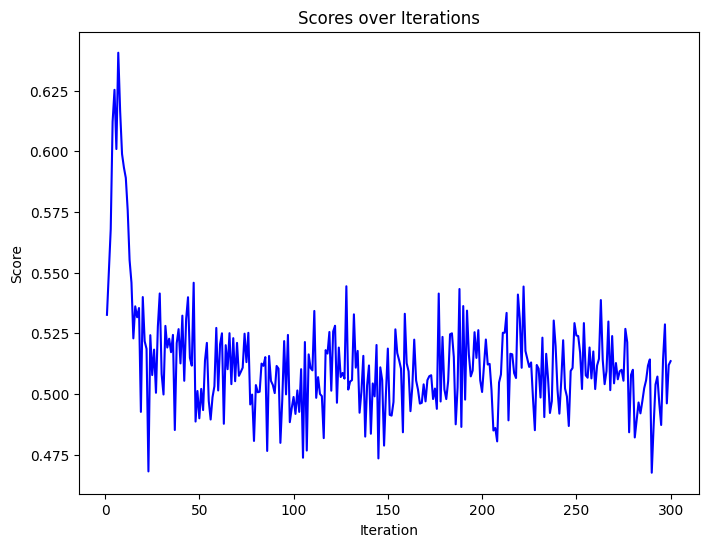

2024-12-05 15:31:54,512 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 0 loss: 1.1022 grad norm: 3.6805 
2024-12-05 15:31:54,966 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 5 loss: 0.0362 grad norm: 0.8082 
2024-12-05 15:31:55,413 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 10 loss: 0.0200 grad norm: 0.4174 
2024-12-05 15:31:55,859 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 15 loss: 0.0156 grad norm: 0.3655 
2024-12-05 15:31:56,304 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 20 loss: 0.0009 grad norm: 0.1055 
2024-12-05 15:31:56,744 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:472] - INFO: [Policy] Epoch: 25 loss: 0.0062 grad norm: 0.2884 
2024-12-05 15:31:57,182 - /home/hanwen/policy_optimiza

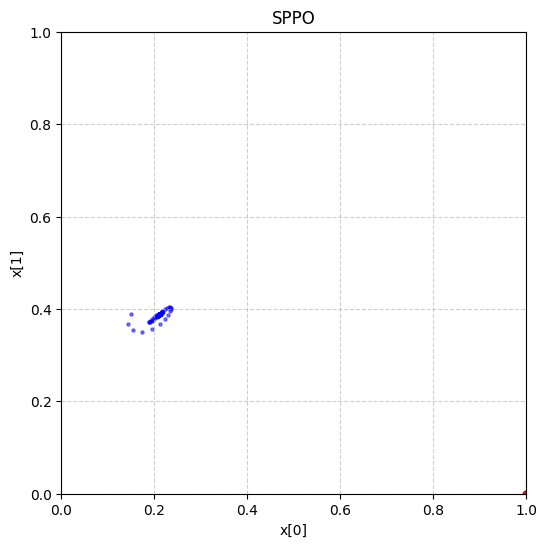

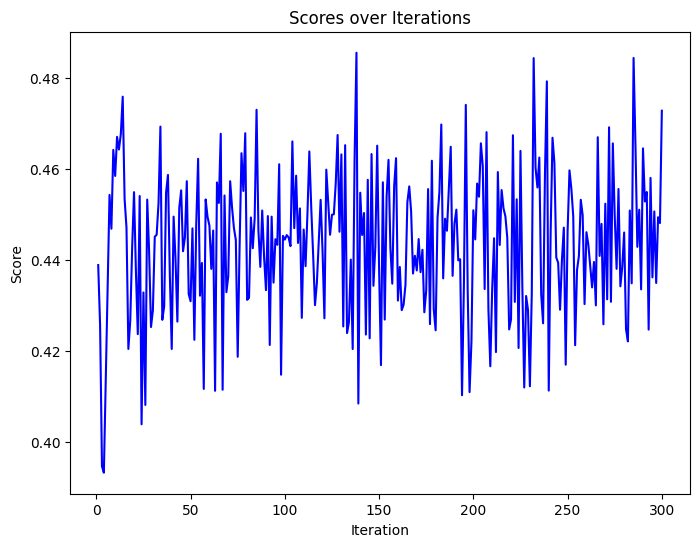

In [101]:
sppo_optimizer_1_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    chosen_probs=chosen_probs_trans,
    p_list=p_list_trans,
    num_epochs=300
)

sppo_optimizer_2_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    chosen_probs=chosen_probs_trans,
    p_list=p_list_trans,
    num_epochs=300
)

sppo_optimizer_3_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    chosen_probs=chosen_probs_trans,
    p_list=p_list_trans,
    num_epochs=300
)

sppo_optimizer_4_trans.optimize(
    states=states_trans,
    positive_actions=positive_actions_trans,
    negative_actions=negative_actions_trans,
    chosen_probs=chosen_probs_trans,
    p_list=p_list_trans,
    num_epochs=300
)

In [102]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_sppo_1_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
score = model_comparison(policy_sppo_1_trans, ref_policy,p_list_trans)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


with torch.no_grad():
    action_probs = policy_sppo_2_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_sppo_2_trans, ref_policy,p_list_trans)
print(f"\nSPPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_3_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_sppo_3_trans, ref_policy,p_list_trans)
print(f"\nSPPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_4_trans(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_sppo_4_trans, ref_policy,p_list_trans)
print(f"\nSPPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.255
P(action=0) = 0.369
P(action=10) = 0.375

SPPO model and base model comparison score: 0.466

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.472
P(action=0) = 0.248
P(action=10) = 0.280

SPPO model and base model comparison score: 0.523

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.383
P(action=0) = 0.311
P(action=10) = 0.307

SPPO model and base model comparison score: 0.514

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.213
P(action=0) = 0.389
P(action=10) = 0.399

SPPO model and base model comparison score: 0.431


### SPPO Close Form

In [115]:
sppo_closed_form_1_trans = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point_trans
)

sppo_closed_form_2_trans = SPPOClosedForm( 
    actions,                      
    score_ref_model = ref_policy,             
    ref_policy=ref_policy2,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_3_trans = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy3,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point_trans
)

sppo_closed_form_4_trans = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy4,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point_trans
)

2024-12-05 15:42:20,978 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.9563, 0.0255, 0.0181]), new_distribution = tensor([0.9565, 0.0254, 0.0181])
2024-12-05 15:42:21,085 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.9565, 0.0254, 0.0181]), new_distribution = tensor([0.9566, 0.0254, 0.0180])
2024-12-05 15:42:21,190 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.9566, 0.0254, 0.0180]), new_distribution = tensor([0.9568, 0.0253, 0.0180])
2024-12-05 15:42:21,296 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.9568, 0.0253, 0.0180]), new_distribution = tensor([0.9569, 0.0252, 0.0179])
2024-12-05 15:42:21,402 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

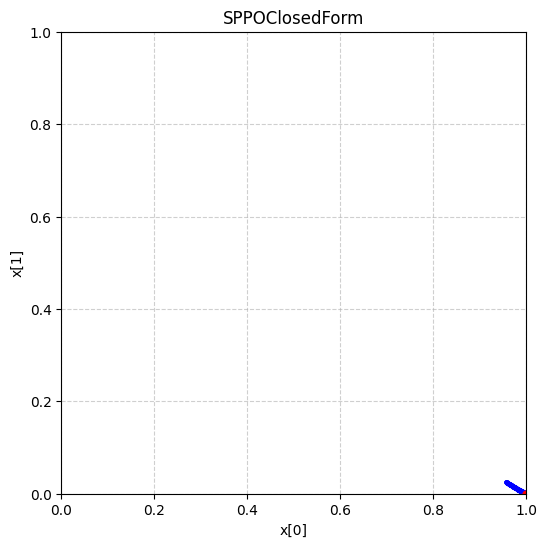

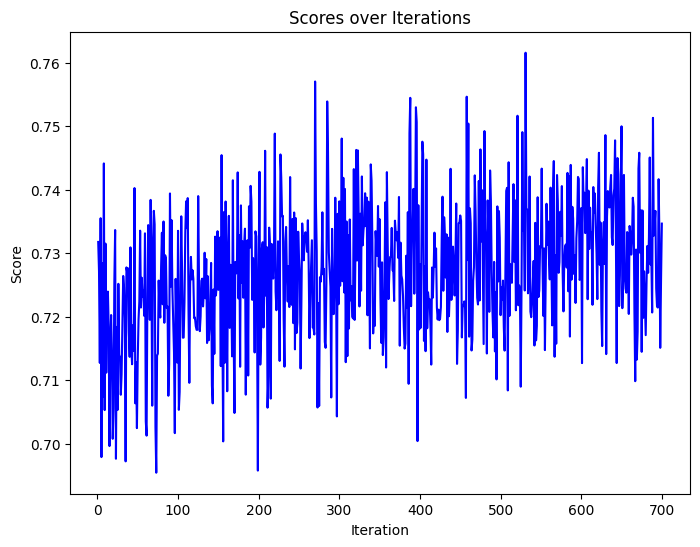

2024-12-05 15:43:01,310 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.7000, 0.2000, 0.1000]), new_distribution = tensor([0.7008, 0.1995, 0.0997])
2024-12-05 15:43:01,366 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.7008, 0.1995, 0.0997]), new_distribution = tensor([0.7016, 0.1990, 0.0994])
2024-12-05 15:43:01,420 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.7016, 0.1990, 0.0994]), new_distribution = tensor([0.7023, 0.1985, 0.0991])
2024-12-05 15:43:01,475 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.7023, 0.1985, 0.0991]), new_distribution = tensor([0.7031, 0.1980, 0.0989])
2024-12-05 15:43:01,529 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

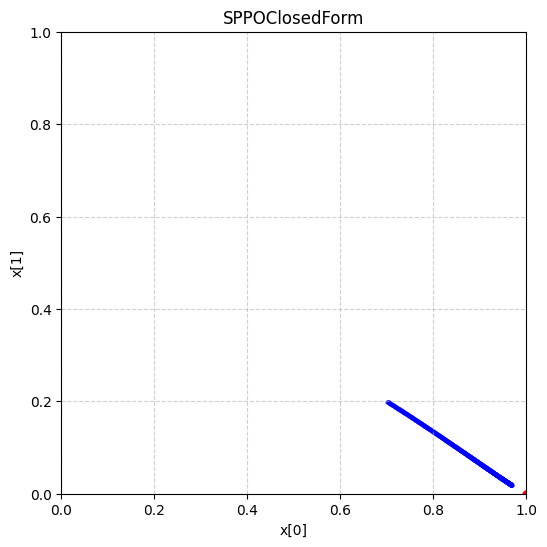

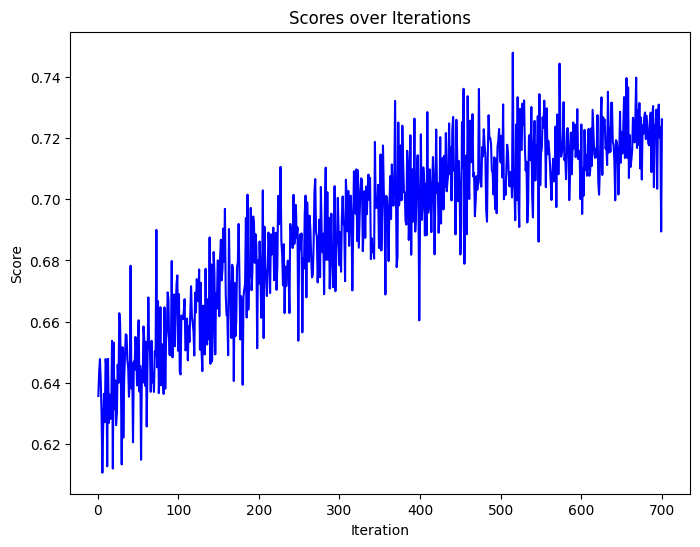

2024-12-05 15:43:39,719 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:43:39,774 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:43:39,828 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:43:39,882 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 0.])
2024-12-05 15:43:39,937 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 4: ref_distribution = tensor([1., 0., 0.]), new_distribution = tensor([1., 0., 

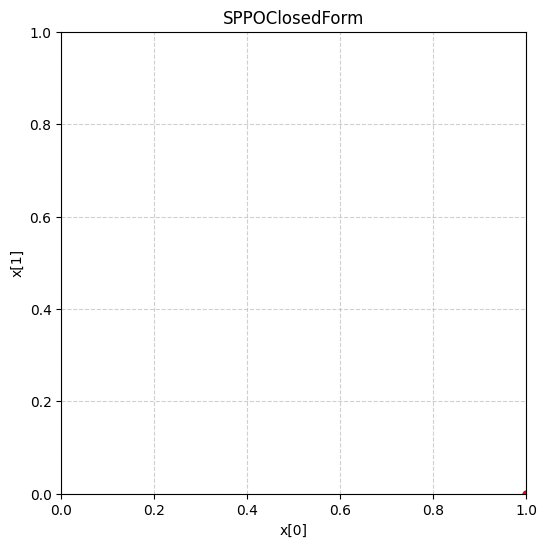

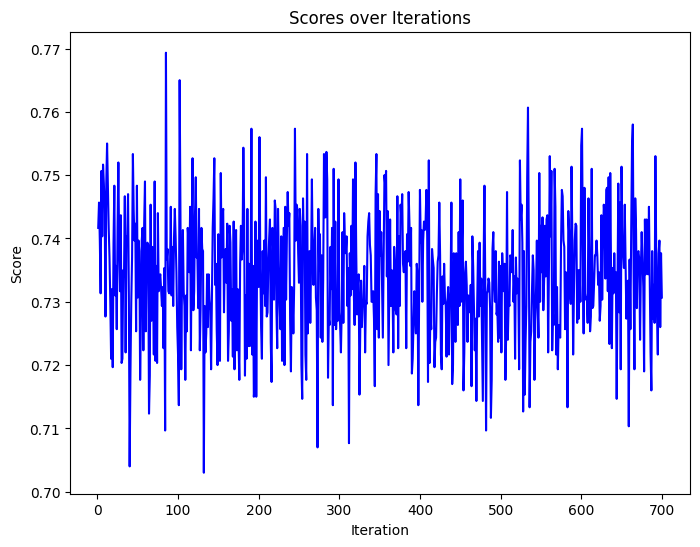

2024-12-05 15:44:17,941 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 0: ref_distribution = tensor([0.1000, 0.3000, 0.6000]), new_distribution = tensor([0.1003, 0.3005, 0.5992])
2024-12-05 15:44:17,997 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 1: ref_distribution = tensor([0.1003, 0.3005, 0.5992]), new_distribution = tensor([0.1006, 0.3009, 0.5984])
2024-12-05 15:44:18,051 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 2: ref_distribution = tensor([0.1006, 0.3009, 0.5984]), new_distribution = tensor([0.1010, 0.3014, 0.5976])
2024-12-05 15:44:18,105 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] - INFO: Iteration 3: ref_distribution = tensor([0.1010, 0.3014, 0.5976]), new_distribution = tensor([0.1013, 0.3019, 0.5968])
2024-12-05 15:44:18,159 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:555] -

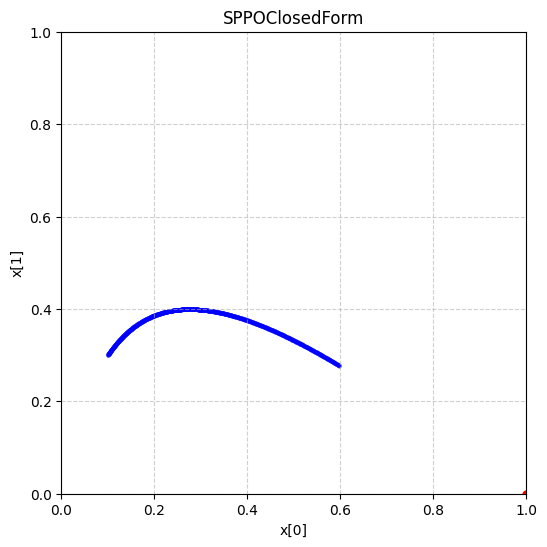

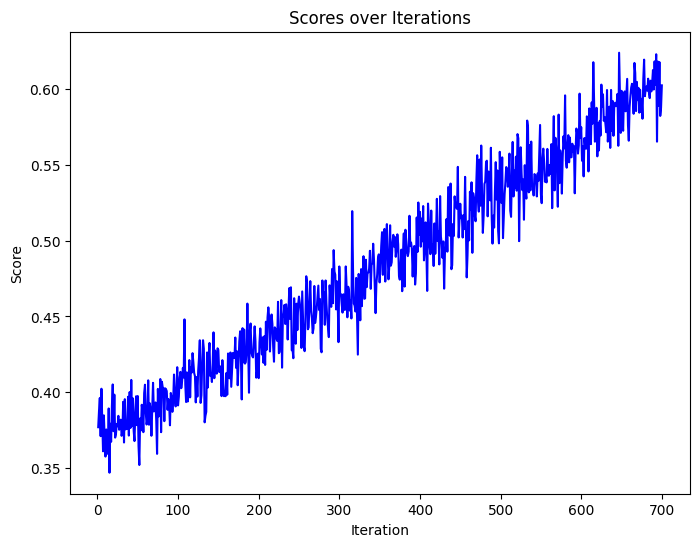

In [116]:
sppo_distribution_1_trans = sppo_closed_form_1.optimize(
    p_list=p_list_trans,
    num_iters=700
)   

sppo_distribution2_trans = sppo_closed_form_2_trans.optimize(
    p_list=p_list_trans,
    num_iters=700
)

sppo_distribution3_trans = sppo_closed_form_3_trans.optimize(
    p_list=p_list_trans,
    num_iters=700
)

sppo_distribution4_trans = sppo_closed_form_4_trans.optimize(
    p_list=p_list_trans,
    num_iters=700
)

In [117]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1_trans = sppo_distribution_1_trans
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1_trans.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1_trans = distribution_comparison(sppo_distribution_1, ref_policy,p_list_trans)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1_trans:.3f}")
    
    
    action_probs_sppo2_trans = sppo_distribution2_trans
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2_trans.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2_trans = distribution_comparison(sppo_distribution2_trans, ref_policy,p_list_trans)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2_trans:.3f}")
    
    
    action_probs_sppo3_trans = sppo_distribution3_trans
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3_trans.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3_trans = distribution_comparison(sppo_distribution3_trans, ref_policy,p_list_trans)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3_trans:.3f}")
    
    
    action_probs_sppo4_trans = sppo_distribution4_trans
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4_trans.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4_trans = distribution_comparison(sppo_distribution4_trans, ref_policy,p_list_trans)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4_trans:.3f}")


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.996
P(action=0) = 0.002
P(action=10) = 0.002

SPPO-ClosedForm model and base model comparison score: 0.508

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.968
P(action=0) = 0.019
P(action=10) = 0.013

SPPO-ClosedForm model and base model comparison score: 0.731

Learned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

SPPO-ClosedForm model and base model comparison score: 0.736

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.598
P(action=0) = 0.277
P(action=10) = 0.125

SPPO-ClosedForm model and base model comparison score: 0.626


## 3 states 6 actions

In [ ]:
state_num = 3
action_num = 18

### Collect data

In [ ]:
import numpy as np

def get_state_p_list(action_num, transitivity_rate, seed=42):
    np.random.seed(seed)
    
    actions = np.arange(action_num)
    p_list = np.zeros((action_num, action_num))
    np.fill_diagonal(p_list, 0.5)  # Self-preference is 0.5
    
    # Select actions in cycle
    cycle_num = int(action_num * transitivity_rate)
    in_cycle_actions = np.random.choice(actions, cycle_num, replace=False)
    
    # Actions not in cycle
    non_cycle_actions = [a for a in actions if a not in in_cycle_actions]
    
    # 1. Form a cycle
    for i in range(len(in_cycle_actions)):
        current = in_cycle_actions[i]
        next_action = in_cycle_actions[(i + 1) % len(in_cycle_actions)]  # Loop back to start
        p_list[current][next_action] = np.round(np.random.uniform(0.7, 1), 2)
        p_list[next_action][current] = np.round(1 - p_list[current][next_action], 2)
    
    # 2. Assign preferences for non-adjacent pairs in cycle
    for i in range(len(in_cycle_actions)):
        for j in range(i + 2, len(in_cycle_actions)):
            a, b = in_cycle_actions[i], in_cycle_actions[j]
            if p_list[a][b] == 0:
                p_list[a][b] = np.round(np.random.uniform(0.7, 1), 2)
                p_list[b][a] = np.round(1 - p_list[a][b], 2)
    
    # 3. Assign preferences within non-cycle actions (linear transitivity)
    for i in range(len(non_cycle_actions)):
        for j in range(i + 1, len(non_cycle_actions)):
            a1, a2 = non_cycle_actions[i], non_cycle_actions[j]
            p_list[a1][a2] = np.round(np.random.uniform(0.7, 1), 2)
            p_list[a2][a1] = np.round(1 - p_list[a1][a2], 2)
    
    # 4. Assign preferences between cycle and non-cycle actions
    for cycle_a in in_cycle_actions:
        for non_cycle_a in non_cycle_actions:
            # In cycle actions are always better than non-cycle actions
            p_list[cycle_a][non_cycle_a] = np.round(np.random.uniform(0.7, 1), 2)
            p_list[non_cycle_a][cycle_a] = np.round(1 - p_list[cycle_a][non_cycle_a], 2)
    

    return p_list, in_cycle_actions


In [ ]:
def get_p_list(state_num, action_num, transitivity_rate, master_seed=42):
    rng = np.random.default_rng(master_seed)
    
    p_list = np.zeros((state_num, action_num, action_num))
    for i in range(state_num):
        seed = rng.integers(0, 1e6)
        p_list[i], in_cycle_actions = get_state_p_list(action_num, transitivity_rate, seed=seed)
        # print(f"\nState {i} cycle actions:", in_cycle_actions)
    return p_list

multi_state_p_list_0 = get_p_list(state_num=3, action_num=6, transitivity_rate=0, master_seed=42)
multi_state_p_list_50 = get_p_list(state_num=3, action_num=6, transitivity_rate=0.5, master_seed=42)
multi_state_p_list_100 = get_p_list(state_num=3, action_num=6, transitivity_rate=1, master_seed=42)
# print("\nGenerated p_list:")
# print(multi_state_p_list_50)
    

In [ ]:
import collections


Transition = collections.namedtuple(
    "Transition", ["state", "action_0", "action_1", "pref", "chosen_probs"]
)

def collect_preference_data_multi_state(
    state_num: int,
    action_num: int,
    sample_size: int,
    p_list: np.ndarray,
) -> List[Transition]:
    
    
    pref_dataset = []
     
    for i in range(state_num):
        cur_state = i
        actions = np.arange(action_num) 
            
        for j in range(sample_size):
            idx_one, idx_two = np.random.choice(len(actions), 2, replace=False)
            action_one = actions[idx_one]
            action_two = actions[idx_two]
        
            bernoulli_param = p_list[i][idx_one][idx_two]
        
            if np.random.random() < bernoulli_param:  
                transition = Transition(
                    cur_state, action_one, action_two, 0, p_list[i][idx_one][idx_two]
                )
            else:
                transition = Transition(
                    cur_state, action_two, action_one, 1, p_list[i][idx_two][idx_one]
                )
            pref_dataset.append(transition)

           
    return pref_dataset,p_list

In [ ]:
pref_dataset_0, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_0)
pref_dataset_50, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_50)
pref_dataset_100, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_100)
len(pref_dataset_0), len(pref_dataset_50), len(pref_dataset_100)

(300, 300, 300)

In [ ]:
pref_dataset_0

[Transition(state=0, action_0=0, action_1=2, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=3, pref=1, chosen_probs=0.07),
 Transition(state=0, action_0=3, action_1=4, pref=0, chosen_probs=0.93),
 Transition(state=0, action_0=3, action_1=5, pref=1, chosen_probs=0.95),
 Transition(state=0, action_0=3, action_1=4, pref=1, chosen_probs=0.93),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=3, action_1=2, pref=1, chosen_probs=0.22),
 Transition(state=0, action_0=0, action_1=3, pref=0, chosen_probs=0.96),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=1, action_1=3, pref=1, chosen_probs=0.76),
 Transition(state=0, action_0=0, action_1=2, pref=0, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=5, pref=0

In [ ]:
def check_data_consistency(pref_dataset):
    consistent = 0
    total = len(pref_dataset)
    
    for t in pref_dataset:
      
        if (t.chosen_probs > 0.5):
            consistent += 1
    
    return consistent / total

In [ ]:
check_data_consistency(pref_dataset_0), check_data_consistency(pref_dataset_50), check_data_consistency(pref_dataset_100)

(0.88, 0.8466666666666667, 0.8733333333333333)

In [ ]:
pref_dataset_0

[Transition(state=0, action_0=0, action_1=2, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=3, pref=1, chosen_probs=0.07),
 Transition(state=0, action_0=3, action_1=4, pref=0, chosen_probs=0.93),
 Transition(state=0, action_0=3, action_1=5, pref=1, chosen_probs=0.95),
 Transition(state=0, action_0=3, action_1=4, pref=1, chosen_probs=0.93),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=3, action_1=2, pref=1, chosen_probs=0.22),
 Transition(state=0, action_0=0, action_1=3, pref=0, chosen_probs=0.96),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=1, action_1=3, pref=1, chosen_probs=0.76),
 Transition(state=0, action_0=0, action_1=2, pref=0, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=5, pref=0

In [ ]:
multi_states_0 = torch.cat([torch.tensor([x.state]) for x in pref_dataset_0], dim=0).to(torch.float32).to(device)
multi_states_idx_0 = [x.state for x in pref_dataset_0]

In [ ]:
positive_actions_multi_states_0 = torch.cat(
    [torch.tensor(x.action_1 if x.pref == 1 else x.action_0).unsqueeze(0) for x in pref_dataset_0],
    dim=0
).to(device)

negative_actions_multi_states_0 = torch.cat(
    [torch.tensor(x.action_0 if x.pref == 1 else x.action_1).unsqueeze(0) for x in pref_dataset_0],
    dim=0
).to(device)

### RLHF

In [ ]:
from utils.plot import plot_scores
from torch.nn import functional as F


class RewardModel_MultiState(nn.Module):
   def __init__(
       self,
       state_dim,
       state_num,
       action_dim,  
       hidden_dim: int = 128,
       num_layers: int = 2,
       device: str = "cpu",
   ):
       super().__init__()
       self.device = torch.device(device)
       self.action_dim = action_dim
       self.state_num = state_num
       
       self.state_feature_extractor = nn.Sequential(
           nn.Linear(state_dim, hidden_dim),
           nn.Tanh(),
           *[nn.Linear(hidden_dim, hidden_dim), nn.Tanh()] * (num_layers-1)
       ).to(self.device)
       

       self.action_feature_extractors = nn.ModuleList([
           nn.Sequential(
               nn.Linear(self.action_dim, hidden_dim),
               nn.Tanh(),
               *[nn.Linear(hidden_dim, hidden_dim), nn.Tanh()] * (num_layers-1)
           ).to(self.device)
           for _ in range(self.state_num)
       ]) # shape: [state_num, action_dim]

       self.predict_layer = nn.Linear(hidden_dim * 2, 1).to(self.device)

   def forward(self, state_idx: int, state: torch.tensor, action: torch.tensor) -> torch.tensor:
       hs = self.state_feature_extractor(state)
       ha = self.action_feature_extractors[state_idx](action)
       h = torch.cat([hs, ha], dim=1)
       return self.predict_layer(h)

In [ ]:
from utils.plot import plot_scores
from torch.nn import functional as F

        
class MaximumLikelihoodEstimator:
    def __init__(
        self,
        action_num: int,
        reward_model: nn.Module,
        learning_rate: float = 1e-3,
        weight_decay: float = 0.0,
        batch_size: int = 64,
        logger: Logger = None,
    ):
        self.action_num = action_num
        self.reward_model = reward_model
        self.batch_size = batch_size
        self.logger = logger

        self.optimizer = torch.optim.AdamW(
            self.reward_model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )

    def optimize_one_epoch(self, states, states_idx, positive_actions, negative_actions):
        total_loss = 0.0
        total_acc = 0.0

        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()

            _states = states[i : i + self.batch_size]
            _states_idx = states_idx[i : i + self.batch_size]
            
            _positive_actions = positive_actions[i : i + self.batch_size]
            _negative_actions = negative_actions[i : i + self.batch_size]

            _positive_actions = F.one_hot(
                _positive_actions, num_classes=self.action_num
            )
            _negative_actions = F.one_hot(
                _negative_actions, num_classes=self.action_num
            )
            
         
            _states = _states.unsqueeze(1) if _states.dim() == 1 else _states
            

            positive_rews = self.reward_model(_states_idx,_states,  _positive_actions)
            negative_rews = self.reward_model( _states_idx,_states, _negative_actions)

            loss = -torch.log(torch.sigmoid(positive_rews - negative_rews)).mean()
            loss.backward()
            self.optimizer.step()

            acc = (positive_rews > negative_rews).float().mean()

            total_loss += loss.item()
            total_acc += acc.item()
            k += 1

        return total_loss / k, total_acc / k

    def optimize(self, states,states_idx, positive_actions, negative_actions, num_epochs):
        for epoch in range(num_epochs):
            loss, acc = self.optimize_one_epoch(
                states,states_idx, positive_actions, negative_actions
            )
            if self.logger:
                if epoch % 2 == 0:
                    self.logger.info(
                        f"[Reward] Epoch {epoch} loss: {loss:.4f} acc: {acc:.2f}"
                    )

class PolicyGradientOptimizer:
    def __init__(
        self,
        policy: nn.Module,
        reward_model: nn.Module,
        ref_policy: nn.Module,  
        score_ref_policy: nn.Module,
        learning_rate: float = 1e-3,
        batch_size: int = 64,
        logger: Logger = None,
        nash_point: List[float] = None,
    ):
        self.policy = policy
        self.reward_model = reward_model
        self.ref_policy = ref_policy
        self.score_ref_policy = score_ref_policy
        
        self.batch_size = batch_size
        self.logger = logger
        self.nash_point = nash_point
        
        self.optimizer = torch.optim.AdamW(
            self.policy.parameters(), lr=learning_rate
        )

    def optimize_one_epoch(self, states):
        total_loss = 0.0
        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()
            
            _states = states[i : i + self.batch_size]
           
            distributions = self.policy(_states)
            ref_distributions = self.ref_policy(_states)        
            
            rewards = self.reward_model(_states, distributions)
            ref_rewards = self.reward_model(_states, ref_distributions)
            
            
            loss = -torch.sum(distributions * rewards, dim=-1).mean()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            k += 1
            
            # record prob of choosing action 0 and action 1
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device) 
            with torch.no_grad():
                action_probs = self.policy(test_state)
                action_probs = action_probs.cpu().numpy()[0] 
            action_0_prob = action_probs[0]
            action_1_prob = action_probs[1]
            
        return total_loss / k, rewards.mean().item(), ref_rewards.mean().item(), action_0_prob, action_1_prob

    def optimize(
        self,
        states: torch.tensor,
        p_list:List[List[float]],
        num_epochs=100):
        
        action_0_probs = []
        action_1_probs = []
        scores = []
        for epoch in range(num_epochs):
            loss, reward, ref_reward, action_0_prob, action_1_prob  = self.optimize_one_epoch(states)
            action_0_probs.append(action_0_prob)
            action_1_probs.append(action_1_prob)
            
            score = model_comparison(self.policy, self.score_ref_policy, p_list)
            scores.append(score)
            
            if epoch % 2 == 0:
                if self.logger:
                    self.logger.info(
                        f"[Policy] Epoch {epoch} "
                        f"loss: {loss:.4f} "
                        f"reward: {reward:.4f} "
                        f"ref_reward: {ref_reward:.4f} "
                        f"improvement: {(reward-ref_reward)/abs(ref_reward):.2%}"
                    )
        two_action_prob_plot(action_0_probs, action_1_probs,self.nash_point,'RLHF')
        plot_scores(scores, num_epochs)

In [ ]:
learned_reward_model_multi_states = RewardModel_MultiState(
    state_dim=1,
    state_num=3,
    action_dim=6,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [ ]:
mle_learner_multi_states = MaximumLikelihoodEstimator(
    action_num,
    learned_reward_model_multi_states,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [ ]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner_multi_states.optimize(
    multi_states_0,multi_states_idx_0, positive_actions_multi_states_0, negative_actions_multi_states_0, num_epochs=20
)

TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
ref_policy_multi_states = UniformPolicyModel(
    state_num,
    action_num=action_num,
    device=device
).to(device)

### DPO

### SPPO

### SPPO closed-form solution

## Summary

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    
    print("\n ##### Learned policy probabilities of RLHF: #####")
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score = model_comparison(policy, ref_policy,p_list)
    print(f"\nRLHF model and base model comparison score: {score:.3f}")


 ##### Learned policy probabilities of RLHF: #####

Learned policy probabilities(RLHF):
P(action=-10) = 0.987
P(action=0) = 0.007
P(action=10) = 0.006

RLHF model and base model comparison score: 0.554


In [ ]:
print("\n ##### Learned policy probabilities of DPO: #####")
with torch.no_grad():
    
    action_probs_dpo1 = policy_dpo_1(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_dpo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo1 = model_comparison(policy_dpo_1, ref_policy,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo1:.3f}")
    
    
    action_probs_dpo2 = policy_dpo_2(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_dpo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo2 = model_comparison(policy_dpo_2, ref_policy2,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo2:.3f}")
    
    
    action_probs_dpo3 = policy_dpo_3(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_dpo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo3 = model_comparison(policy_dpo_3, ref_policy3,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo3:.3f}")
    
    
    action_probs_dpo4 = policy_dpo_4(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_dpo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_dpo4 = model_comparison(policy_dpo_4, ref_policy4,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo4:.3f}")


 ##### Learned policy probabilities of DPO: #####

Learned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.476
P(action=0) = 0.214
P(action=10) = 0.310



DPO model and base model comparison score: 0.508

Learned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.840
P(action=0) = 0.082
P(action=10) = 0.079

DPO model and base model comparison score: 0.527

Learned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 0.982
P(action=0) = 0.008
P(action=10) = 0.010

DPO model and base model comparison score: 0.497

Learned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.241
P(action=0) = 0.181
P(action=10) = 0.578

DPO model and base model comparison score: 0.494


In [ ]:
print("\n ##### Learned policy probabilities of SPPO: #####")
with torch.no_grad():
    action_probs_sppo1 = policy_sppo_1(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = model_comparison(policy_sppo_1, ref_policy,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = policy_sppo_2(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = model_comparison(policy_sppo_2, ref_policy2,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = policy_sppo_3(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = model_comparison(policy_sppo_3, ref_policy3,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = policy_sppo_4(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = model_comparison(policy_sppo_4, ref_policy4,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo4:.3f}")


 ##### Learned policy probabilities of SPPO: #####

Learned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.304
P(action=0) = 0.309
P(action=10) = 0.387


TypeError: 'NonMonotonicScalarToVectorNN' object is not subscriptable

In [ ]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1 = sppo_distribution_1
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = distribution_comparison(sppo_distribution_1, ref_policy,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = sppo_distribution2
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = distribution_comparison(sppo_distribution2, ref_policy2,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = sppo_distribution3
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = distribution_comparison(sppo_distribution3, ref_policy3,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = sppo_distribution4
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = distribution_comparison(sppo_distribution4, ref_policy4,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4:.3f}")
        


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.410
P(action=0) = 0.337
P(action=10) = 0.252


TypeError: 'NonMonotonicScalarToVectorNN' object is not subscriptable